<a href="https://colab.research.google.com/github/viraj-sampat/vwm_research/blob/main/digit_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from IPython.display import IFrame
from IPython.display import display_pdf
from IPython.display import FileLink
from IPython.display import display
import os

# Import Data

In [23]:
training_data = torchvision.datasets.MNIST('dataset', train=True,download=True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST('dataset', train=False, download=True, transform = transforms.ToTensor())

batch_size = 256
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True)

# Visualize Data

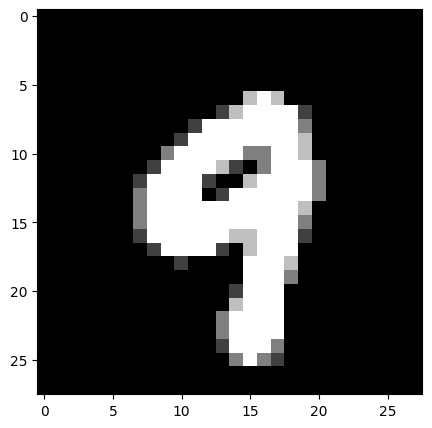

In [24]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Create Model

In [25]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        
        output_channels = 2
        kernel_size = 4
        encoding_dimension = 20
        self.encoder = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size = kernel_size),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(output_channels*((28-kernel_size+1)**2), encoding_dimension),
            nn.ReLU(True)
            )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dimension, output_channels*((28-kernel_size+1)**2)),
            nn.ReLU(True),
            nn.Unflatten(1, (output_channels, 28-kernel_size+1, 28-kernel_size+1)),
            nn.ConvTranspose2d(output_channels, 1, kernel_size = kernel_size),
            nn.Sigmoid()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MNISTAutoencoder().to(device)

# Initialize Loss and Optimizer

In [27]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# Train Model

In [28]:
num_epochs = 10
print('Training Model...')
for epoch in range(num_epochs):
    training_loss = 0.0
    for data in train_loader:
        image, _ = data
        image = image.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_function(output, image)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    print('Epoch {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss/len(train_loader)))
        
        

Training Model...
Epoch 1/10, Loss: 0.0565
Epoch 2/10, Loss: 0.0287
Epoch 3/10, Loss: 0.0251
Epoch 4/10, Loss: 0.0239
Epoch 5/10, Loss: 0.0234
Epoch 6/10, Loss: 0.0230
Epoch 7/10, Loss: 0.0227
Epoch 8/10, Loss: 0.0224
Epoch 9/10, Loss: 0.0222
Epoch 10/10, Loss: 0.0221


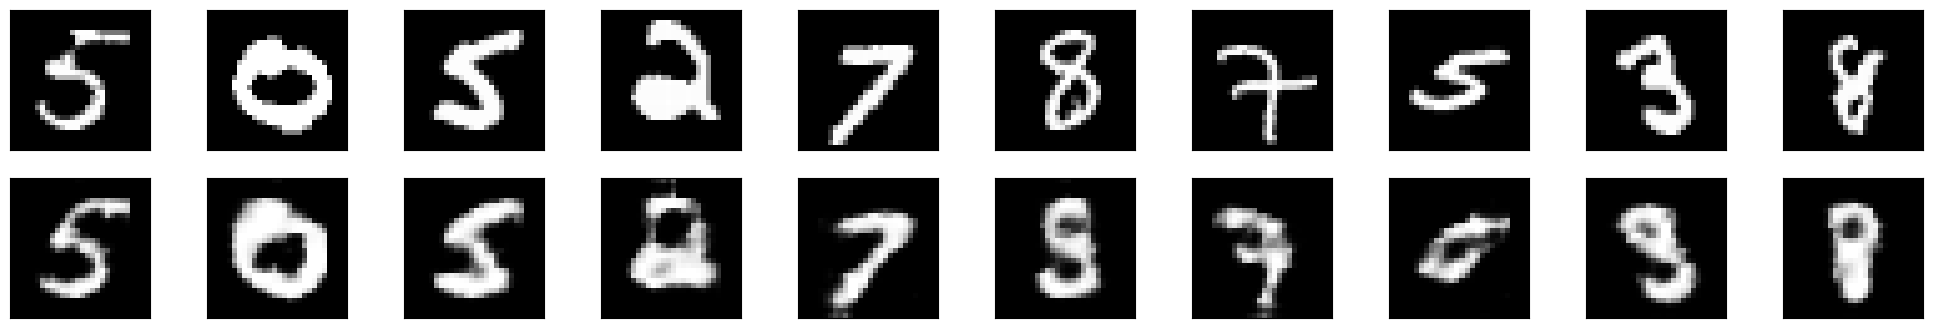

In [29]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)

output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)